In [135]:
%matplotlib inline

In [136]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

In [137]:
rnaseq_file = '../Data/raw_data/41467_2019_13483_MOESM4_ESM.xlsx'

In [138]:
metadata_df = pd.read_excel(rnaseq_file, sheet_name='Metadata')
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'].isnull() == False]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'] > 0.0]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Alignment'] > 80]
print(metadata_df.shape)

(278, 26)
(195, 26)
(179, 26)
(173, 26)


In [139]:
expression_df = pd.read_excel(rnaseq_file, sheet_name='Expression Data', index_col=0)
print(expression_df.shape)
expression_df = expression_df[metadata_df['Sample ID']]
print(expression_df.shape)

(3923, 278)
(3923, 173)


In [ ]:
assert list(metadata_df['Sample ID']) == list(expression_df.columns)

In [ ]:
expression_df = expression_df / expression_df.sum()

In [ ]:
tempy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    tempy.append((index, rho, p))
tempy.sort(key=lambda x: x[1])

In [ ]:
tempy

In [ ]:
a = metadata_df['Growth Rate (1/hr)']
b = expression_df.sum()

fig, ax = plt.subplots()
ax.scatter(a,b)

In [ ]:
metadata_df['Growth Rate (1/hr)'].hist()

In [ ]:
tempy = []
for column in expression_df.columns:
    rho, p = stats.spearmanr(expression_df[expression_df.columns[0]], expression_df[column])
    tempy.append((column, rho, p))
tempy.sort(key=lambda x: x[1])

In [ ]:
tempy

In [140]:
other_df = pd.read_csv('../Data/ecoli_info/temp_ecoli_master_table.tsv', sep='\t', index_col=0)
print(other_df.shape)
other_df = other_df[other_df['CAI'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['roc_semppr_mean'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['iCUB'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['tAI'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['stAIcalc'].isnull()==False]
print(other_df.shape)

(4355, 12)
(4310, 12)
(4310, 12)
(4310, 12)
(4310, 12)
(4310, 12)


In [141]:
other_df

,gene,start_loc,stop_loc,strand,cds_seq,us_seq,well_behaved,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc
locus_tag,,,,,,,,,,,,
b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,True,32.046035,1.244106,0.617266,0.262286,0.258417
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,True,55.949262,1.034078,0.353246,0.230564,0.216862
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,True,56.062386,0.994168,0.357812,0.216292,0.210420
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,True,53.052776,1.176750,0.394675,0.231407,0.209784
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,True,50.705530,0.837528,0.374371,0.197715,0.208944
...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,True,55.967103,0.829794,0.293537,0.212672,0.206721
b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,True,54.634345,0.739848,0.288635,0.210078,0.199677
b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,True,48.981781,1.676448,0.530773,0.275348,0.239921


In [142]:
print(expression_df.shape)
expression_df = expression_df[expression_df.index.isin(other_df.index)]
print(expression_df.shape)
other_df = other_df[other_df.index.isin(expression_df.index)]
print(other_df.shape)

(3923, 173)
(3859, 173)
(3859, 12)


In [143]:
expression_df = expression_df.sort_index()
other_df = other_df.sort_index()

In [150]:
metric = 'roc_semppr_mean'
tempy = []
listy_a = []
listy_b = []
for column in expression_df.columns:
    rho, p = stats.spearmanr(other_df[metric], expression_df[column])
    listy_a.append(rho)
    listy_b.append(metadata_df[metadata_df['Sample ID']==column].iloc[0]['Growth Rate (1/hr)'])
    tempy.append((column, rho, p))
tempy.sort(key=lambda x: x[1])

SpearmanrResult(correlation=0.39898524857337786, pvalue=5.409645376352678e-08)
0.3957754416125814


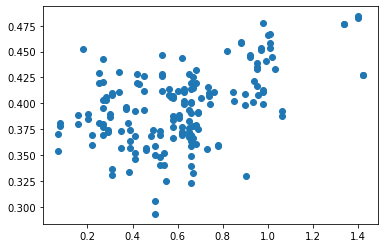

In [151]:
fig, ax = plt.subplots()
ax.scatter(listy_b, listy_a)
print(stats.spearmanr(listy_b, listy_a))
print(np.mean(listy_a))

LinregressResult(slope=2.6921268546854957, intercept=5.212546147996024, rvalue=0.47674313264797125, pvalue=2.995654777823106e-218, stderr=0.07992749524484961)


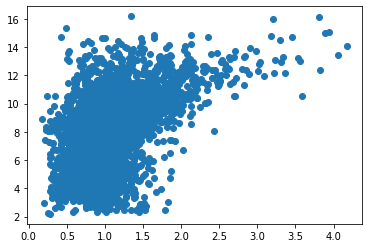

In [163]:
metric = 'roc_semppr_mean'
fig, ax = plt.subplots()
ax.scatter(other_df[metric], expression_df.max(axis=1))
print(stats.linregress(other_df[metric], expression_df.max(axis=1)))

In [37]:
other_df

,gene,start_loc,stop_loc,strand,cds_seq,us_seq,well_behaved,CAI,roc_semppr_mean
locus_tag,,,,,,,,,
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,True,0.353246,1.034078
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,True,0.357812,0.994168
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,True,0.394675,1.176750
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,True,0.374371,0.837528
b0006,yaaA,5682,6459,-,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,GTCGGCATAAATTTCCTGCAAGGACTGGAT,True,0.353849,1.032499
...,...,...,...,...,...,...,...,...,...
b4676,yoaK,1878772,1878871,+,ATGCGAATCGGTATTATTTTTCCGGTTGTAATCTTCATTACAGCGG...,CGTATTCACATCCTTTTGATTGGTGATAAC,True,0.315836,0.783099
b4686,yshB,4053646,4053757,-,ATGCTGGAATCAATAATTAATCTGGTATCGAGTGGCGCAGTTGACA...,GATCTTGCCCGGAAAACGGGGAGAGTCATT,True,0.320157,0.841343
b4688,ykgS,290509,290638,+,ATGAGAATGATTGGCCTTCTTTATGATTTTAAGGATTATGCTTCTA...,ATCGAATTCTACAACCAGGTCGAGTCAGAA,True,0.245198,0.632458


In [ ]:
expression_df

In [164]:
listy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    listy.append(rho)
other_df['hunch'] = listy

SpearmanrResult(correlation=-0.23734821565667888, pvalue=1.4739639524345305e-50)


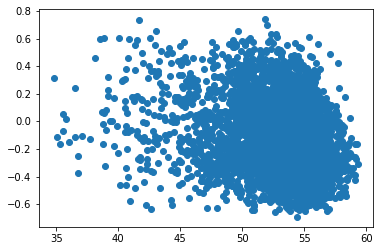

In [168]:
metric = 'iCUB'
fig, ax = plt.subplots()
ax.scatter(other_df[metric], other_df['hunch'])
print(stats.spearmanr(other_df[metric], other_df['hunch']))

SpearmanrResult(correlation=0.04569411046135154, pvalue=0.0052507801370892514)


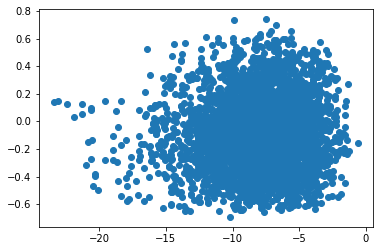

In [101]:
fig, ax = plt.subplots()
ax.scatter(other_df['Start_accessibility'], other_df['hunch'])
print(stats.spearmanr(other_df['Start_accessibility'], other_df['hunch']))

SpearmanrResult(correlation=-0.05775832810906073, pvalue=0.0004166914462606806)


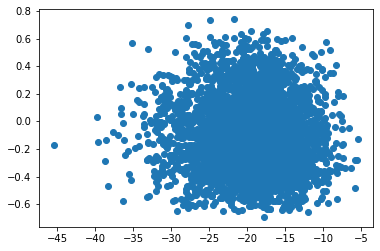

In [102]:
fig, ax = plt.subplots()
ax.scatter(other_df['sec_struct'], other_df['hunch'])
print(stats.spearmanr(other_df['sec_struct'], other_df['hunch']))

SpearmanrResult(correlation=0.0764867793082473, pvalue=2.916439887056762e-06)


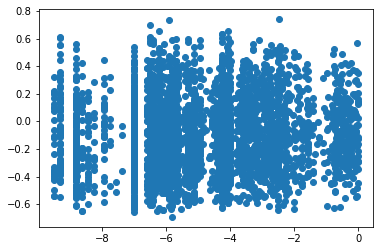

In [103]:
fig, ax = plt.subplots()
ax.scatter(other_df['aSD_binding'], other_df['hunch'])
print(stats.spearmanr(other_df['aSD_binding'], other_df['hunch']))

In [67]:
import statsmodels.formula.api as smf

In [185]:
plot_df = pd.DataFrame(zip(other_df['CAI'], expression_df.max(axis=1), listy))
plot_df.columns = ['codon_metric', 'expression_summary', 'growth_summary']

In [186]:
fitted_model = smf.ols('codon_metric ~ expression_summary * growth_summary', data=plot_df).fit()
print(fitted_model.pvalues)
fitted_model.summary()

Intercept                            1.201398e-287
expression_summary                   2.085459e-248
growth_summary                        5.563325e-17
expression_summary:growth_summary     4.129076e-49
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           codon_metric   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     753.9
Date:                Wed, 23 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:08:43   Log-Likelihood:                 4326.7
No. Observations:                3859   AIC:                            -8645.
Df Residuals:                    3855   BIC:                            -8620.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2072      0.005     39.566      0.000       0.197       0.217
expression_summary                    0.0215      0.001     36.297      0.000       0.020       0.023
growth_summary                       -0.1558      0.019     -8.413      0.000      -0.192      -0.119
expression_summary:growth_summary     0.0304      0.002     14.941      0.000       0.026       0.034
==============================================================================
Omnibus:                      365.807   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.959
Skew:                           0.664   Prob(JB):                    2.94e-139
Kurtosis:                       4.485   Cond. No.                         126.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""